# Necessary Imports



In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

# Dataset

The data is taken from the UCI Machine Learning Repository. A csv file is available in the /raw-data directory and can also be downloaded from the source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease . While there are multiple datasets available, we have use the one processed by the Cleveland Clinic Foundation. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# step1: import raw data into a pandas dataframe
rawdf = pd.read_csv("/content/sample_data/cleve_heart_data.csv")
data = rawdf.copy()

In [ ]:
#Step2: Explore its contents
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
data.shape

(303, 14)

# 2.Data Pre-processing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [ ]:
#Check object datatypes
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

In [ ]:
#Step 3: Check for missing values
data.isnull().values.any()

False

In [ ]:
#Great. No missing values to deal with. 
#Check values of response
data["num"].unique()

array([0, 2, 1, 3, 4])

In [ ]:
#Step 4: Convert response variable to bindary values i.e. make all num values >0 to 1
data.loc[data.num>0,["num"]] = 1

In [ ]:
data["num"].unique()

array([0, 1])

In [ ]:
#Step 5 & 6: Divide into train and test dataframes & Drop all columns except thalach and chol


#Setting a random seed ensures that the splits are reproducible
np.random.seed(143)

msk = np.random.rand(len(data)) < 0.75
train = data[msk][["thalach", "chol", "num"]]
test = data[~msk][["thalach", "chol", "num"]]

In [ ]:
#Check how the split looks
train.shape, test.shape

((228, 3), (75, 3))

In [ ]:
#write train and test dataframes to csv files without index columns
train.to_csv("train.csv", index = False)
test.to_csv("test.csv", index = False)

In [ ]:
#Read train and test datasets
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [ ]:
#Take a look at the contents of traindf
traindf.head()

,thalach,chol,num
0,150.0,233.0,0
1,108.0,286.0,1
2,129.0,229.0,1
3,187.0,250.0,0
4,172.0,204.0,0


In [ ]:
traindf.dtypes

thalach    float64
chol       float64
num          int64
dtype: object

In [ ]:
#Convert train and test dataframes into X,y numpy arrays
X_train = traindf.values[:,:-1]
y_train = traindf.values[:,-1]

X_test = testdf.values[:,:-1]
y_test = testdf.values[:,-1]

In [ ]:
X_train.shape

(228, 2)

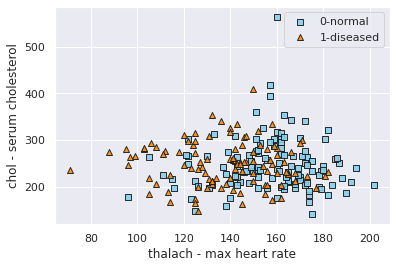

In [ ]:
#Visualize training data on a scatter plot
sns.set(style='darkgrid')
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1], c='skyblue', marker= 's', edgecolors='k', alpha =0.9, label = '0-normal')
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1], c='darkorange', marker= '^', edgecolors='k', alpha =0.9, label = '1-diseased')

plt.legend()
plt.xlabel("thalach - max heart rate")
plt.ylabel("chol - serum cholesterol")
plt.savefig("/content/sample_data/eda.png")
plt.show()

In [ ]:
#Plot correlation plot
traindf[["thalach","chol"]].corr(method = "pearson")

,thalach,chol
thalach,1.000000,-0.012114
chol,-0.012114,1.000000


- The Pearson coefficients indicate that the predictors are not linearly correlated.

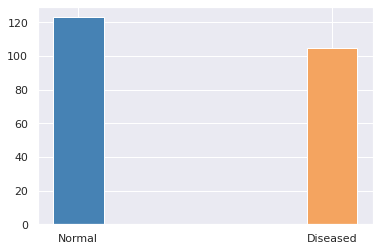

Proportion of diseased cases: 0.46


In [ ]:
#Check whether the training set is balanced
unique_classes,counts = np.unique(y_train,return_counts = True)
class_names = ["Normal","Diseased"]

sns.set(style='darkgrid')
plt.bar(class_names, counts, width=0.2, color=['steelblue','sandybrown'])
plt.show()

print("Proportion of diseased cases: {}".format(round(counts[1]/len(y_train),2)))

In this case, we define the metric for model performance as classification accuracy on the test set. Let us first build functions for measuring performance and to visualize decision boundary.

In [ ]:
#Function to get test accuracy
def accuracy(X, y, model):
    return round(accuracy_score(y,model.predict(X)),2)

In [ ]:
#function to plot decision boundary
def plot_regions(X,y,model,ax,title):
    plt.sca(ax)
    plot_decision_regions(X=X, y=y.astype(np.integer), clf=model, legend =2)
    
    plt.title(title)
    plt.xlabel("thalach")
    plt.ylabel("cols")


## 3. Building models
<a id="models"> </a>

### 3.1. Decision tree

In [ ]:
#Build a pipeline
tree_steps = [('standardizer', StandardScaler()),('tree', DecisionTreeClassifier(random_state =42))]
tree_pipe = Pipeline(tree_steps)

In [ ]:
#define tree params - max depth of 2 to 20
tree_params = {"tree__max_depth":list(range(2,20))}

In [ ]:
#Hyperparamter tuning and model fitting
tree = GridSearchCV(tree_pipe,param_grid = tree_params, cv=10, scoring = "accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('tree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                             

In [ ]:
#Best hyperparameters
tree.best_params_

{'tree__max_depth': 2}

In [ ]:
#Performance
DTCscore_test = tree.score(X_test,y_test)
DTCscore_train = tree.score(X_train,y_train)

print("Decision Tree Test Score: ",tree.score(X_test,y_test))
print("Decision Tree Train Score: ",tree.score(X_train,y_train))



Decision Tree Test Score:  0.7066666666666667
Decision Tree Train Score:  0.7017543859649122


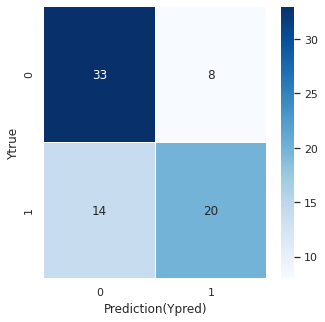

In [ ]:
yprediciton2= tree.predict(X_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton2)

#CM visualization

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after re

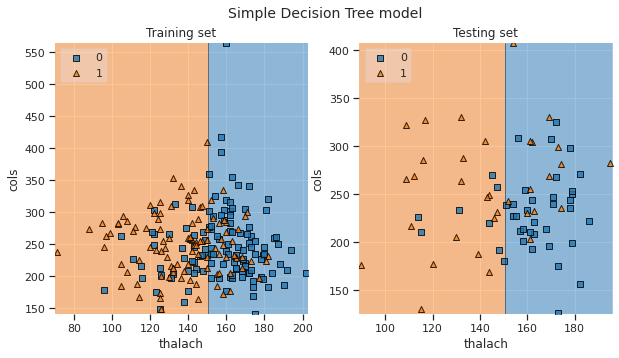

In [ ]:
#Visualizing classification
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train, y_train, tree, ax[0],"Training set")
plot_regions(X_test,y_test, tree,ax[1], "Testing set")

fig.suptitle("Simple Decision Tree model", fontsize=14)
plt.savefig("/content/sample_data/simpletree.png")
plt.show()

### 3.2. Ensemble methods
<a id="ensemble"> </a>

### 3.2.1 Bagging
<a id="bagging"> </a>

In [ ]:
#Build a bagging pipeline
bag_steps = [('standardizer', StandardScaler()),('bag', BaggingClassifier(random_state=42))]
bag_pipe = Pipeline(bag_steps)

- The hyperparameter in bagging is the number of trees in the ensemble. We will tune this paramter using 5-fold cross-validation.

In [ ]:
#Hyper-parameter tuning
#n-estimators == no. of trees
bag_params = {"bag__n_estimators":list(range(2,11))}
bag = GridSearchCV(bag_pipe,param_grid = bag_params, cv=10, scoring = "accuracy")
bag.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('bag',
                                        BaggingClassifier(base_estimator=None,
                                                          bootstrap=True,
                                                          bootstrap_features=False,
                                                          max_features=1.0,
                                                          max_samples=1.0,
                                                          n_estimators=10,
                                                          n_jobs=None,
                                                          oob_score=Fals

In [ ]:
#Best hyperparameters
bag.best_params_

{'bag__n_estimators': 4}

In [ ]:
#Performance
print("Training accuracy is: {}".format(accuracy(X_train, y_train,bag)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,bag))) 

Training accuracy is: 0.93
Testing accuracy is: 0.6


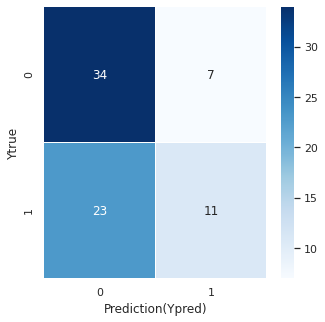

In [ ]:
yprediciton2= bag.predict(X_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton2)

#CM visualization

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after re

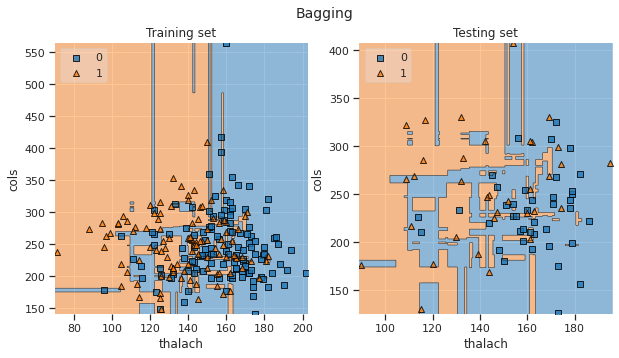

In [ ]:
#Visualizing classification
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, bag,ax[0], "Training set")
plot_regions(X_test,y_test, bag,ax[1], "Testing set")

fig.suptitle("Bagging", fontsize=14)
plt.savefig("/content/sample_data/bag.png")
plt.show()

### 3.2.3. Boosting

In [ ]:
#Build an adaboost pipe
boost_steps = [('standardizer', StandardScaler()),('boost', AdaBoostClassifier(random_state=42))]
boost_pipe = Pipeline(boost_steps)

In [ ]:
#hyperparamter tuning
#n-estimators == no. of trees and learning rate == shrinks weightage of each additional tree in the ensemble(controls for overfitting)
boost_params = {"boost__n_estimators":list(range(2,20)), "boost__learning_rate":[0.001,0.01,0.1,1,1.4,1.8,2,3,4]}
boost = GridSearchCV(boost_pipe,param_grid = boost_params, cv=10)
boost.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('boost',
                                        AdaBoostClassifier(algorithm='SAMME.R',
                                                           base_estimator=None,
                                                           learning_rate=1.0,
                                                           n_estimators=50,
                                                           random_state=42))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'boost__learning_rate': [0.001, 0.01, 0.1, 1, 1.4, 1.8,
                                      

In [ ]:
#Best hyperparameters
boost.best_params_

{'boost__learning_rate': 2, 'boost__n_estimators': 5}

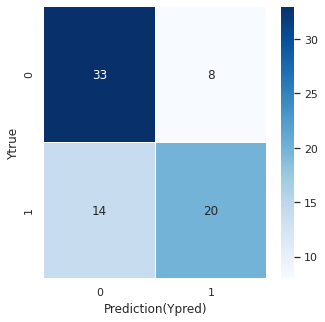

In [ ]:
yprediciton2= boost.predict(X_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton2)

#CM visualization

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

In [ ]:
Adascore=boost.score(X_test,y_test)

print("AdaBoost Test Score: ",boost.score(X_test,y_test))
print("AdaBoost Train Score: ",boost.score(X_train,y_train))
#Performance


AdaBoost Test Score:  0.7066666666666667
AdaBoost Train Score:  0.7017543859649122


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after re

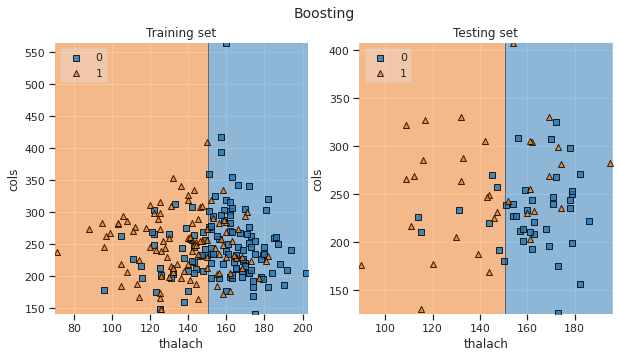

In [ ]:
#Classification visualization
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, boost,ax[0], "Training set")
plot_regions(X_test,y_test, boost,ax[1], "Testing set")

fig.suptitle("Boosting", fontsize=14)
plt.savefig("/content/sample_data/boost.png")
plt.show()

**Results:** This is an interesting result. It is evident that AdaBoost gave us a classification region that is very similar to our simple decision tree. One possible explanation for this is that the data did not provide any further information required to reduce errors predicted by our base estimator.


### Choosing the best model

Now that we have analyzed, let us choose the best performing one and see how it can be deployed in practice.

In [ ]:
#Comparing performance of all models
acc_dict = {}

all_models = [tree, bag, boost]
all_model_names = ["tree","bagging","adaboost"]
for i in range(len(all_models)):
    acc_dict[all_model_names[i]] = accuracy(X_test,y_test,all_models[i])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


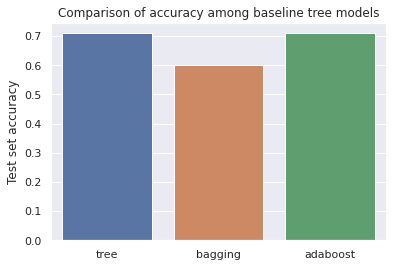

In [ ]:
#Plot performance comparison bar plot
sns.barplot(list(acc_dict.keys()), list(acc_dict.values()))
plt.title("Comparison of accuracy among baseline tree models")
plt.ylabel("Test set accuracy")
plt.savefig("/content/sample_data/perfcomparison")

###3.3 Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)  #learning 
#SVM Test 

SVMscore_test = svc.score(x_test, y_test)
SVMscore_train = svc.score(x_train, y_train)
print ("SVM Test Accuracy:", svc.score(x_test,y_test))

print ("SVM Train Accuracy:", svc.score(x_train, y_train))

SVM Test Accuracy: 0.8524590163934426
SVM Train Accuracy: 0.9132231404958677


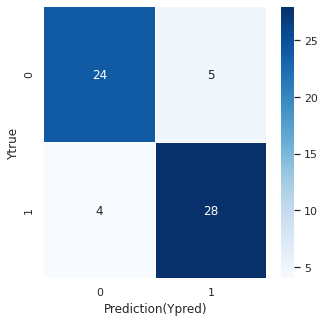

In [ ]:
yprediciton2= svc.predict(x_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton2)

#CM visualization

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

###3.4 Random Forest

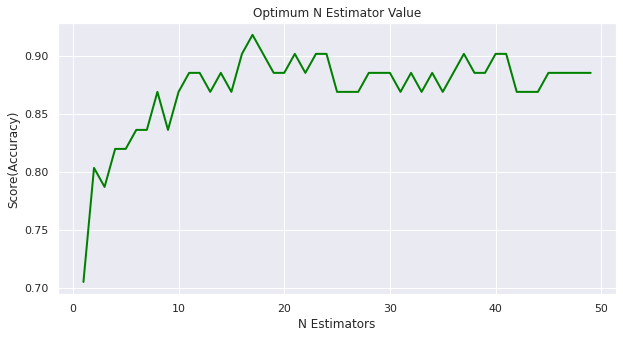

In [ ]:
random_state = 42
scores = []
for each in range(1,50):
    rf = RandomForestClassifier(n_estimators = each,random_state=random_state,max_depth=3)
    rf.fit(x_train,y_train)
    scores.append(rf.score(x_test,y_test))
    
plt.figure(1, figsize=(10, 5))
plt.plot(range(1,50),scores,color="green",linewidth=2)
plt.title("Optimum N Estimator Value")
plt.xlabel("N Estimators")
plt.ylabel("Score(Accuracy)")
plt.grid(True)
plt.show()

In [ ]:
rf= RandomForestClassifier(n_estimators = 19, random_state=random_state,max_depth=3) #n_estimator = DT
rf.fit(x_train,y_train) # learning
RFCscore=rf.score(x_test,y_test)

print("Random Forest Test Score: ",rf.score(x_test,y_test))
print("Random Forest Train Score: ",rf.score(x_train,y_train))

Random Forest Test Score:  0.8852459016393442
Random Forest Train Score:  0.8760330578512396


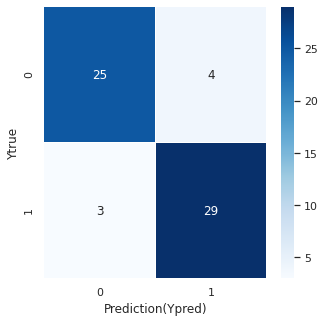

In [ ]:
yprediciton2= rf.predict(x_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton2)

#CM visualization

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

###3.5 Voting Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
v1 = VotingClassifier(estimators = [('svc',svc),('dt',tree),('rf',rf),('ada',boost)])
v1.fit(x_train,y_train) # learning
vooting1=v1.score(x_test,y_test)

print("Voting C. Test Score: ",v1.score(x_test,y_test))
print("Voting C. Train Score: ",v1.score(x_train,y_train))

Voting C. Test Score:  0.8852459016393442
Voting C. Train Score:  0.8884297520661157


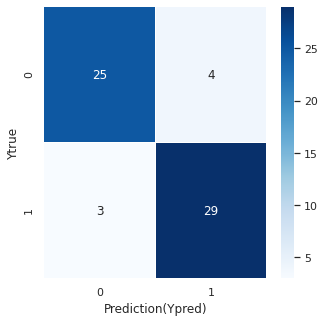

In [ ]:
yprediciton5= v1.predict(x_test)
ytrue = y_test

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytrue,yprediciton5)

import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
plt.xlabel("Prediction(Ypred)")
plt.ylabel("Ytrue")
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

scores=[SVMscore_test,DTCscore_test,RFCscore,Adascore,vooting1]
AlgorthmsName=["SVM","Decision Tree","Random Forest","Adaboost",'Voting Classifier -1-']

#create traces

trace1 = go.Scatter(
    x = AlgorthmsName,
    y= scores,
    name='Algortms Name',
    marker =dict(color='rgba(0,255,0,0.5)',
               line =dict(color='rgb(0,0,0)',width=2)),
                text=AlgorthmsName
)
data = [trace1]

layout = go.Layout(barmode = "group",
                  xaxis= dict(title= 'ML Algorithms',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Prediction Scores',ticklen= 5,zeroline= False))
fig = go.Figure(data = data, layout = layout)
iplot(fig)